In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import keras
from keras import backend as K
from keras.layers import Input, Dense, Dropout
from keras.layers.advanced_activations import PReLU
from keras.models import Model
from keras.optimizers import Adamax
import math
import matplotlib
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import matplotlib
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


In [2]:

# Model fixed parameters
NInputs = 4 # Number of features (model inputs)
NOutputs = 1 # Number of targets (model outputs)



In [3]:

# Import training data (model inputs & outputs)
Feature_Train = pd.read_csv('processed_data/SL_Train_Features.csv', header = 0)
Feature_Train = Feature_Train[['GR', 'RHOB','NPHI','RPCELM_l10']]

Feature_Train = np.asarray(Feature_Train)
print(Feature_Train.shape)
Target_Train = pd.read_csv('processed_data/SL_Train_Target.csv', header = 0)
Target_Train = Target_Train[['SW']]
Target_Train = np.asarray(Target_Train)
print(Target_Train.shape)
print(Feature_Train[0])


# Import validation data (model inputs & outputs)
Feature_Val = pd.read_csv('processed_data/SL_Val_Features.csv', header = 0)
Feature_Val = Feature_Val[['GR', 'RHOB','NPHI','RPCELM_l10']]

Feature_Val = np.asarray(Feature_Val)
print(Feature_Val.shape)
Target_Val = pd.read_csv('processed_data/SL_Val_Target.csv', header = 0)
Target_Val = Target_Val[['SW']] 
Target_Val = np.asarray(Target_Val)
print(Target_Val.shape)



# Import test data (model inputs & outputs)
Feature_Test = pd.read_csv('processed_data/SL_Test_Features.csv', header = 0)
Feature_Test = Feature_Test[['GR', 'RHOB','NPHI','RPCELM_l10']]

Feature_Test = np.asarray(Feature_Test)
print(Feature_Test.shape)
Target_Test = pd.read_csv('processed_data/SL_Test_Target.csv', header = 0)
Target_Test = Target_Test[['SW']] 
Target_Test = np.asarray(Target_Test)
print(Target_Test.shape)



(14061, 4)
(14061, 1)
[21.6229      2.288       0.1833     -0.45618019]
(6027, 4)
(6027, 1)
(8882, 4)
(8882, 1)


In [4]:
# Defining neural network

rate = 0.1

def nn():
    NN_ip = Input(shape=(NInputs,))
    x = Dense(1000)(NN_ip)
    x = PReLU()(x)
    x = Dropout(rate)(x)
    x = Dense(1000)(x)
    x = PReLU()(x)
    x = Dropout(rate)(x)
    NN_op = Dense(NOutputs)(x)
       
    NN_model = Model(NN_ip, NN_op)
    
    def loss_mse(true, pred):
        mean = pred[:, :NOutputs]
        return K.mean(K.square(true - mean), -1)

    def metric_mse(y_true, y_pred):
        mean = y_pred[:, :NOutputs]
        return K.mean(K.square(y_true - mean), -1)
    
    opt = Adamax(1e-3)
    
    NN_model.compile(loss = loss_mse, optimizer = opt, metrics = [metric_mse])
    
    return NN_model

NN = nn()
NN.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 1000)              5000      
_________________________________________________________________
p_re_lu (PReLU)              (None, 1000)              1000      
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 1000)              1000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0     

Epoch 1/300
9/9 [==============================] - 3s 236ms/step - loss: 72.8796 - metric_mse: 72.8796 - val_loss: 0.2172 - val_metric_mse: 0.2172
Epoch 2/300
9/9 [==============================] - 1s 125ms/step - loss: 4.0328 - metric_mse: 4.0328 - val_loss: 0.0817 - val_metric_mse: 0.0817
Epoch 3/300
9/9 [==============================] - 1s 126ms/step - loss: 0.7800 - metric_mse: 0.7800 - val_loss: 0.3273 - val_metric_mse: 0.3273
Epoch 4/300
9/9 [==============================] - 1s 129ms/step - loss: 0.3632 - metric_mse: 0.3632 - val_loss: 0.1234 - val_metric_mse: 0.1234
Epoch 5/300
9/9 [==============================] - 1s 125ms/step - loss: 0.3626 - metric_mse: 0.3626 - val_loss: 0.1683 - val_metric_mse: 0.1683
Epoch 6/300
9/9 [==============================] - 1s 126ms/step - loss: 0.3276 - metric_mse: 0.3276 - val_loss: 0.1345 - val_metric_mse: 0.1345
Epoch 7/300
9/9 [==============================] - 1s 129ms/step - loss: 0.2847 - metric_mse: 0.2847 - val_loss: 0.0710 - val_me

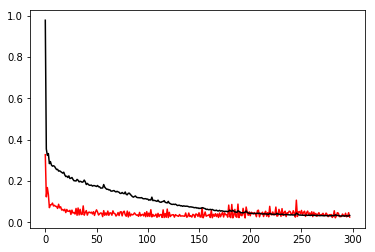

In [5]:
NN = nn()

history = NN.fit(Feature_Train, Target_Train, 
                     epochs = 300, 
                     batch_size = int(Feature_Train.shape[0]/8), 
                     shuffle = True, 
                     validation_data = (Feature_Val, Target_Val))
    
plt.plot(history.history['val_loss'][2:],'r')
plt.plot(history.history['loss'][2:],'k')


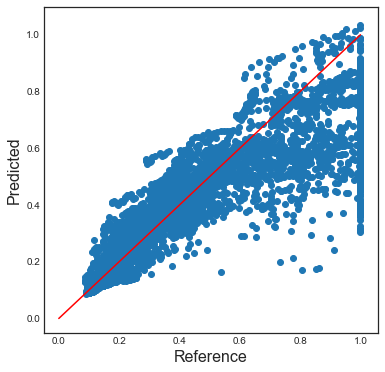

In [6]:
#3.1 Plot the predicted saturation versus the Interpreted saturation
PredictedTarget = NN.predict(Feature_Test)
plt.figure(figsize = (6,6))
plt.style.use('seaborn-white')
plt.scatter(Target_Test, PredictedTarget)
plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), color = 'r', alpha = 1)
plt.xlabel('Reference', FontSize = 16)
plt.ylabel('Predicted', FontSize = 16)
plt.show()


In [7]:

SaveWeights = 0
LoadWeights = 0
localmodelname_h5 = ('NNWeights.h5')

if SaveWeights:
    NN.save_weights(localmodelname_h5) # saving model parameters

if LoadWeights:
    NN = nn()
    NN.load_weights(localmodelname_h5)



In [8]:
output_df = pd.read_csv('processed_data/SL_Test_Target.csv', header = 0)
type(output_df)
output_df.insert( 4,"PredictedSw", PredictedTarget)
output_df
output_df.to_csv('processed_data/SL_PredictedSw.csv', index=True)

In [9]:
output_df['SwDifference'] = abs(output_df['PredictedSw'] - output_df['SW'])

## Plotting the Prediction Results
After the prediction has completed, we can view the predicted result against the actual measurement on the test well: 15/9-F-11 B

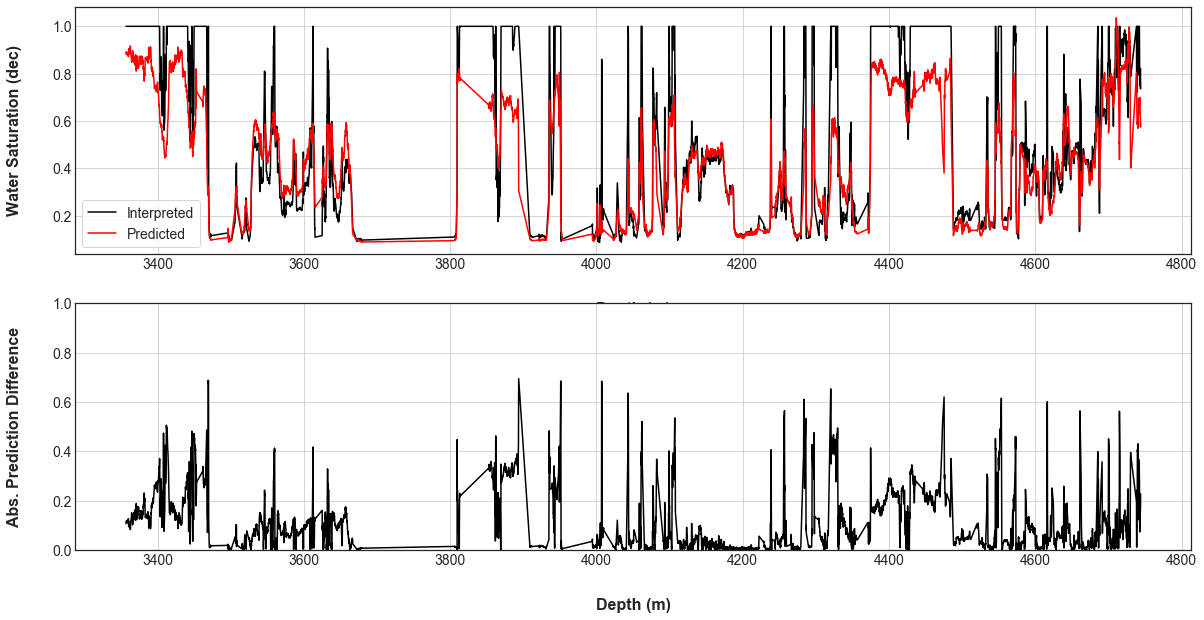

In [10]:
fig, ax = plt.subplots(3, 1, figsize=(20,10))

ax1 = plt.subplot2grid((2,1), (0,0))
ax2 = plt.subplot2grid((2,1), (1,0))

ax1.plot(output_df['MD'], output_df['SW'], label='Interpreted', color='black')
ax1.plot(output_df['MD'], output_df['PredictedSw'], label='Predicted', color='red')

ax1.set_ylabel('Water Saturation (dec)', fontsize=16, fontweight='bold', labelpad=30)
ax1.set_xlabel('Depth (m)', fontsize=16, fontweight='bold', labelpad=30)
ax1.tick_params(which='both', labelsize=14)


ax2.plot(output_df['MD'], output_df['SwDifference'], label='Interpreted', color='black')
ax2.set_ylim(0,1)

ax2.set_ylabel('Abs. Prediction Difference', fontsize=16, fontweight='bold', labelpad=30)

for ax in [ax1, ax2]:
    ax.grid()
    ax.set_axisbelow(True)
    ax.set_xlabel('Depth (m)', fontsize=16, fontweight='bold', labelpad=30)
    ax.tick_params(which='both', labelsize=14)

ax1.legend(fontsize=14, facecolor='white', frameon=True)

plt.show()